# **LOADING THE COMPLETE DATASET**

In [6]:
import pandas as pd
hf_model_data = pd.read_csv('/content/hf_model_data.csv')

In [7]:
hf_model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14040 entries, 0 to 14039
Data columns (total 81 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   admission_type                        14040 non-null  int64  
 1   admission_location                    14040 non-null  int64  
 2   discharge_location                    14040 non-null  int64  
 3   insurance                             14040 non-null  int64  
 4   marital_status                        14040 non-null  int64  
 5   ethnicity                             14040 non-null  int64  
 6   hospital_expire_flag                  14040 non-null  int64  
 7   has_chartevents_data                  14040 non-null  int64  
 8   readmit_30_days                       14040 non-null  int64  
 9   gender                                14040 non-null  int64  
 10  age                                   14040 non-null  int64  
 11  num_diagnoses  

In [8]:
hf_model_data.drop(columns=['discharge_location'], inplace=True)
#DATA LEAKEGE

# **Visualizing Class Separation using PCA and t-SNE**

The model was understandably performing poorly on the minority class (Class 1 - readmission). To gain deeper insight into the underlying structure and assess whether the classes are naturally separable, we visualized the data using Principal Component Analysis (PCA) and t-distributed Stochastic Neighbor Embedding (t-SNE).

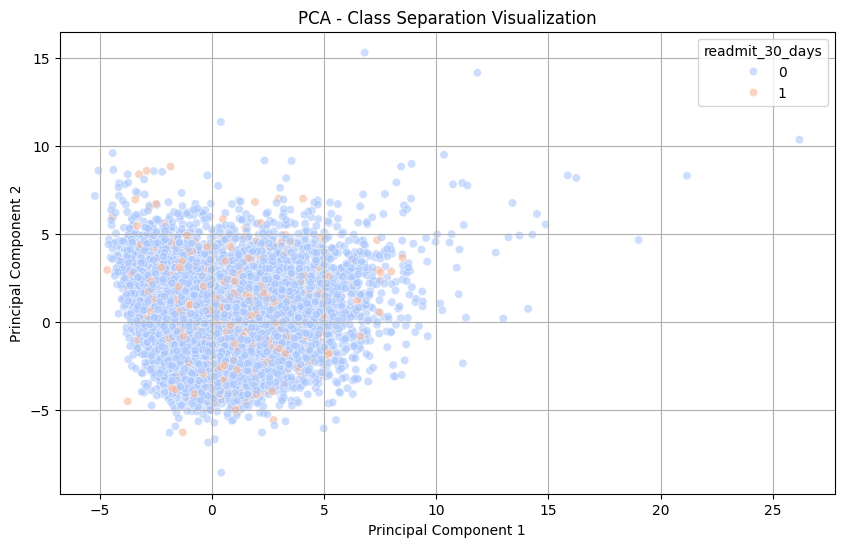

In [9]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Extract features and target
X = hf_model_data.drop(columns=['readmit_30_days'])
y = hf_model_data['readmit_30_days']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)


# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y, palette='coolwarm', alpha=0.6)
plt.title("PCA - Class Separation Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


In [10]:
from sklearn.utils import resample

# Combine X and y into one DataFrame
df = pd.concat([pd.DataFrame(X_scaled), y.reset_index(drop=True)], axis=1)

# Downsample class 0
class_0 = df[df['readmit_30_days'] == 0]
class_1 = df[df['readmit_30_days'] == 1]
class_0_downsampled = resample(class_0, replace=False, n_samples=1000, random_state=42)
class_1_sampled = resample(class_1, replace=False, n_samples=300, random_state=42)  # smaller class

df_sampled = pd.concat([class_0_downsampled, class_1_sampled])
X_sampled = df_sampled.drop('readmit_30_days', axis=1)
y_sampled = df_sampled['readmit_30_days']

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


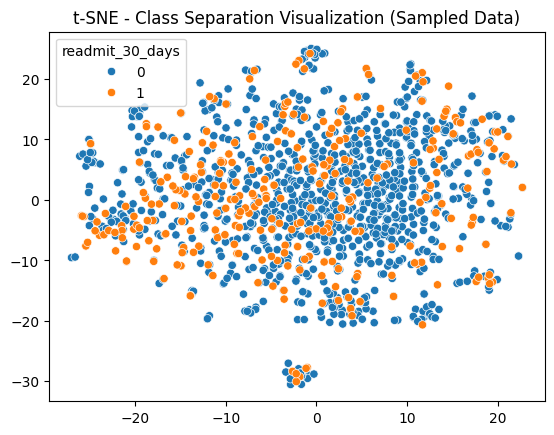

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=500)
X_tsne = tsne.fit_transform(X_sampled)

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_sampled)
plt.title("t-SNE - Class Separation Visualization (Sampled Data)")
plt.show()
##The data likely does not have strong distinguishing patterns between readmitted and non-readmitted patients using the features input to t-SNE.
#The features we're using don't contain enough signal to clearly distinguish readmitted (1) from non-readmitted (0) patients.

**OBSERVATION:**

Even after scaling, the feature space does not linearly separate the two classes. There's significant overlap between Class 0 and Class 1, indicating that the classes are not easily distinguishable using linear decision boundaries.

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

df=pd.read_csv('/content/hf_model_data.csv')

X = df.drop(columns=['readmit_30_days'])
y = df['readmit_30_days']

clf = RandomForestClassifier(n_estimators=50, class_weight='balanced')
scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print("Cross-validated AUCs:", scores)
print("Average AUC:", scores.mean())

#Our average AUC = 0.67, which means:
#The features do contain useful signal for predicting 30-day readmissions.
# The model is learning, just not performing well on our test split or final evaluation. That narrows the problem down.

Cross-validated AUCs: [0.67975015 0.68197327 0.66520283 0.64549827 0.64283714]
Average AUC: 0.6630523321657497


---


# **CLASS IMBALANCE VISUALIZATION**

<ipython-input-12-760924fcd50d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='readmit_30_days', data=hf_model_data, palette='viridis')


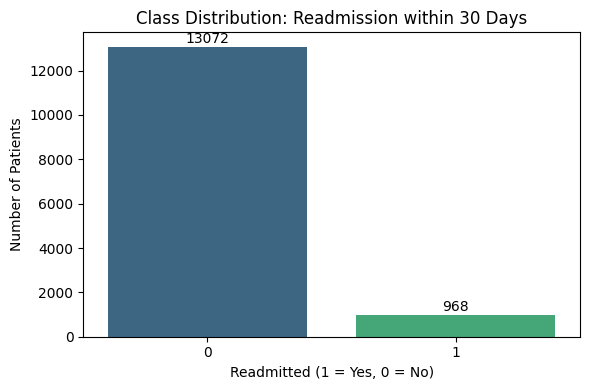

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count plot
plt.figure(figsize=(6, 4))
sns.countplot(x='readmit_30_days', data=hf_model_data, palette='viridis')

# Annotations
plt.title('Class Distribution: Readmission within 30 Days')
plt.xlabel('Readmitted (1 = Yes, 0 = No)')
plt.ylabel('Number of Patients')

# Show counts on bars
counts = hf_model_data['readmit_30_days'].value_counts()
for i, count in enumerate(counts):
    plt.text(i, count + 50, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


Around 93-4% of dataset is of class 0 and 6-7% is of class 1.

Sampling techniques will be applied later to handle this better.

# **FEATURE SELECTION**


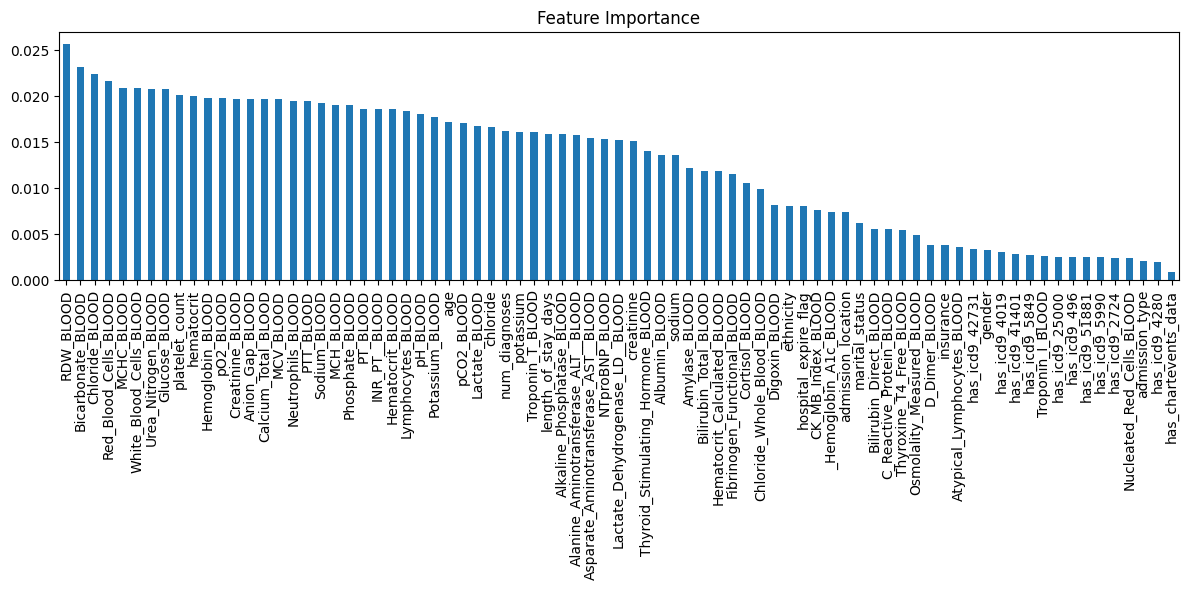

In [13]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

X = hf_model_data.drop(columns=['readmit_30_days'])
y = hf_model_data['readmit_30_days']

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get importance
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title="Feature Importance")
plt.tight_layout()
plt.show()

In [14]:
# Sort feature importances
sorted_importances = importances.sort_values(ascending=False)

# View top N 20
print(sorted_importances.head(20))

# Set threshold
threshold = 0.01

# Filter features above threshold
selected_features = sorted_importances[sorted_importances > threshold].index.tolist()

# Reduce your data
X_selected = X[selected_features]

RDW_BLOOD                  0.025680
Bicarbonate_BLOOD          0.023151
Chloride_BLOOD             0.022382
Red_Blood_Cells_BLOOD      0.021621
MCHC_BLOOD                 0.020963
White_Blood_Cells_BLOOD    0.020865
Urea_Nitrogen_BLOOD        0.020785
Glucose_BLOOD              0.020748
platelet_count             0.020183
hematocrit                 0.020087
Hemoglobin_BLOOD           0.019799
pO2_BLOOD                  0.019777
Creatinine_BLOOD           0.019737
Anion_Gap_BLOOD            0.019716
Calcium_Total_BLOOD        0.019707
MCV_BLOOD                  0.019675
Neutrophils_BLOOD          0.019543
PTT_BLOOD                  0.019502
Sodium_BLOOD               0.019295
MCH_BLOOD                  0.019070
dtype: float64


In [15]:
print(f"Total features before: {X.shape[1]}")
print(f"Total features after selection: {len(selected_features)}")

Total features before: 79
Total features after selection: 49


# **Train-Test Split with Stratification**

To evaluate model performance reliably, we split our data into training and testing sets using an 80/20 ratio. We also applied stratified sampling to ensure that the class distribution (especially the minority class) remains consistent in both sets. This helps prevent skewed evaluation metrics due to class imbalance.

In [16]:
from sklearn.model_selection import train_test_split

# First split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

---

# **Sampling Techniques for Class Imbalance**

To address the significant imbalance in our dataset, we experimented with a variety of resampling strategies to improve model performance on the minority class. These included:

* **Undersampling:** Reducing the number of majority class samples to balance the dataset.
* **Oversampling:** Increasing the number of minority class samples through duplication.
* **SMOTE (Synthetic Minority Over-sampling Technique):** Creating synthetic examples of the minority class based on nearest neighbors.
* **SMOTE-ENN:** A hybrid approach that combines SMOTE with Edited Nearest Neighbors for better cleaning and resampling.
* **Class Weighting (e.g., `scale_pos_weight` in XGBoost):** Adjusting the importance of classes directly in the model's loss function to counteract imbalance without modifying the dataset.

Each of these techniques was evaluated to understand its impact on model precision, recall, and overall generalization.



---

## 1. SMOTE ON TRAINING DATASET

In [17]:
#let's try SMOTE
from imblearn.over_sampling import SMOTE
# 2. Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

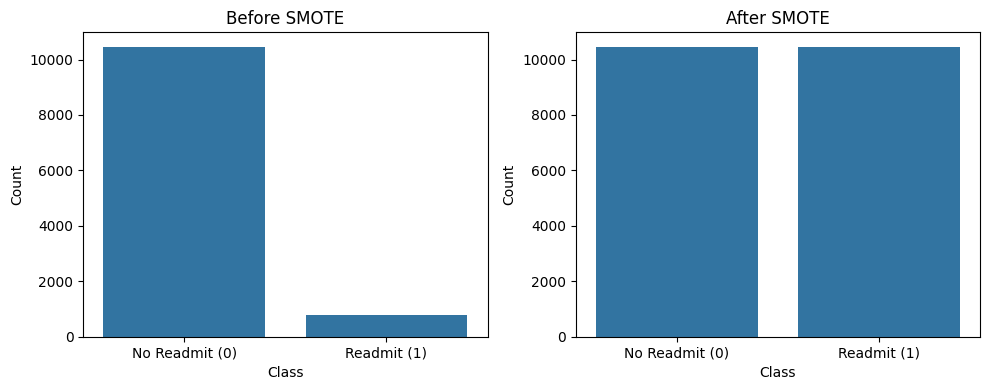

In [18]:
# Plotting side by side comparison
plt.figure(figsize=(10, 4))

# Before SMOTE
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Readmit (0)', 'Readmit (1)'])

# After SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_smote)
plt.title('After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Readmit (0)', 'Readmit (1)'])

plt.tight_layout()
plt.show()


## 2. SMOTENN

In [19]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)


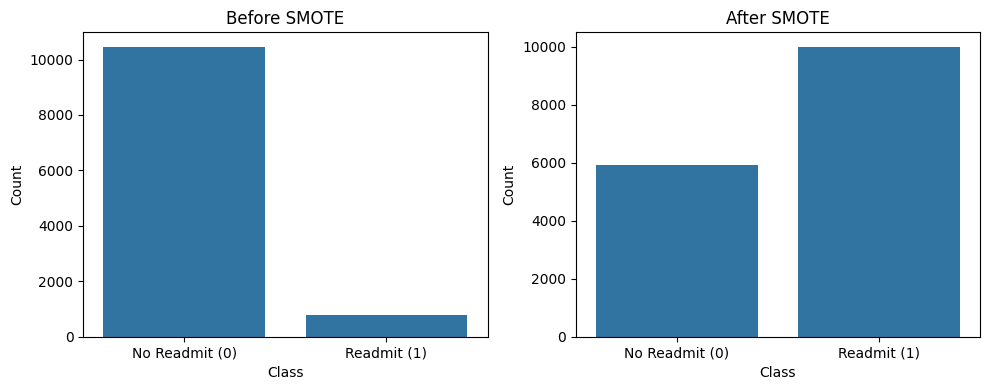

In [20]:
plt.figure(figsize=(10, 4))

# BEFORE: Original distribution
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Readmit (0)', 'Readmit (1)'])

# AFTER: Distribution after SMOTEENN
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled)
plt.title('After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Readmit (0)', 'Readmit (1)'])

plt.tight_layout()
plt.show()

### Single function to call and evaluate various models with multiple sampling techniques


In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Check if model supports predict_proba
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        raise ValueError("The provided model does not support predict_proba().")

    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("AUROC Score:", roc_auc_score(y_test, y_pred_proba))

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    print("PR-AUC Score:", pr_auc)



#TESTING Random Forest WITH MULTIPLE Sampling Techniques

### Using class_weight=balance

In [22]:
from sklearn.ensemble import RandomForestClassifier

# 1. Baseline: class_weight='balanced' only
rf_balanced = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_balanced.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [23]:
print("1. RF with class_weight='balanced'")
evaluate_model(rf_balanced, X_test, y_test)

1. RF with class_weight='balanced'
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      2614
           1       0.00      0.00      0.00       194

    accuracy                           0.93      2808
   macro avg       0.47      0.50      0.48      2808
weighted avg       0.87      0.93      0.90      2808

Confusion Matrix:
 [[2614    0]
 [ 194    0]]
AUROC Score: 0.6512001198936732
PR-AUC Score: 0.11402287130956987


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### using SMOTEENN

In [24]:
rf_smoteenn = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smoteenn.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [25]:
print("2. RF trained on SMOTEENN resampled data")
evaluate_model(rf_smoteenn, X_test, y_test)

2. RF trained on SMOTEENN resampled data
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90      2614
           1       0.12      0.25      0.16       194

    accuracy                           0.82      2808
   macro avg       0.53      0.56      0.53      2808
weighted avg       0.88      0.82      0.85      2808

Confusion Matrix:
 [[2264  350]
 [ 146   48]]
AUROC Score: 0.6478507875910047
PR-AUC Score: 0.10388736787737063


### USING SMOTE

In [26]:
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)


RandomForestClassifier(random_state=42)

In [27]:
print("3. RF trained on SMOTE oversampled data")
evaluate_model(rf_smote, X_test, y_test)

3. RF trained on SMOTE oversampled data
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      2614
           1       0.17      0.11      0.13       194

    accuracy                           0.90      2808
   macro avg       0.55      0.53      0.54      2808
weighted avg       0.88      0.90      0.89      2808

Confusion Matrix:
 [[2513  101]
 [ 173   21]]
AUROC Score: 0.6429732053415786
PR-AUC Score: 0.10720216204022004


### USING SMOTE + CLASS weight=balance

In [28]:
rf_smote_balanced = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_smote_balanced.fit(X_train_smote, y_train_smote)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [29]:
print("4. RF with class_weight='balanced' trained on SMOTE data")
evaluate_model(rf_smote_balanced, X_test, y_test)

4. RF with class_weight='balanced' trained on SMOTE data
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      2614
           1       0.17      0.11      0.13       194

    accuracy                           0.90      2808
   macro avg       0.55      0.53      0.54      2808
weighted avg       0.88      0.90      0.89      2808

Confusion Matrix:
 [[2513  101]
 [ 173   21]]
AUROC Score: 0.6429732053415786
PR-AUC Score: 0.10720216204022004


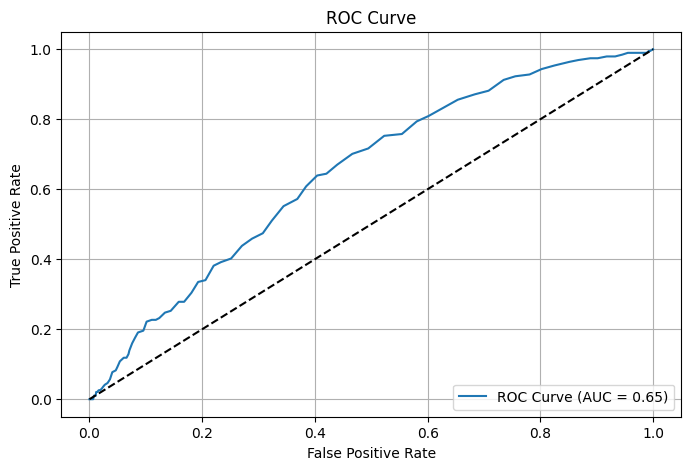

In [31]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = rf_smoteenn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

We tested four Random Forest models to handle class imbalance:

1. **Class\_weight='balanced' only:** High accuracy (93%) but failed to predict any minority class cases (0% recall), resulting in poor minority detection (AUROC 0.65, PR-AUC 0.11).

2. **SMOTEENN resampling:** Improved minority recall to 25% with low precision (12%), accuracy dropped to 82%. Slightly better at detecting positives but with more false positives.

3. **SMOTE oversampling:** Minority recall 11%, precision 17%, accuracy 90%. Balanced predictions better than SMOTEENN but minority detection still weak.

4. **SMOTE + class\_weight='balanced':** Similar to SMOTE alone with no notable improvement.

**Summary:** Resampling helps minority recall but overall minority class detection remains poor, highlighting the dataset’s imbalance challenge.


# Balanced Random Forest

In [32]:
#trying balanced RF
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

brf = BalancedRandomForestClassifier(n_estimators=200, random_state=42)
brf.fit(X_train, y_train)



BalancedRandomForestClassifier(n_estimators=200, random_state=42)

In [33]:
# Predictions
y_pred_brf = brf.predict(X_test)
y_prob_brf = brf.predict_proba(X_test)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred_brf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_brf))
print("AUROC Score:", roc_auc_score(y_test, y_prob_brf))

# PR-AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob_brf)
pr_auc = auc(recall, precision)
print("PR-AUC Score:", pr_auc)


              precision    recall  f1-score   support

           0       0.94      0.86      0.90      2614
           1       0.15      0.32      0.20       194

    accuracy                           0.82      2808
   macro avg       0.55      0.59      0.55      2808
weighted avg       0.89      0.82      0.85      2808

Confusion Matrix:
 [[2253  361]
 [ 132   62]]
AUROC Score: 0.6818706173735397
PR-AUC Score: 0.12614641621980957


We applied a Balanced Random Forest classifier which improved minority class detection compared to previous models. It achieved 32% recall and 15% precision for the minority class, with overall accuracy of 82%. The AUROC increased to 0.68 and PR-AUC to 0.13, showing better performance in identifying positive cases while maintaining reasonable accuracy.

# EasyEnsemble

In [34]:
from imblearn.ensemble import EasyEnsembleClassifier

eec = EasyEnsembleClassifier(n_estimators=50, random_state=42)
eec.fit(X_train, y_train)


EasyEnsembleClassifier(n_estimators=50, random_state=42)

In [35]:
# Predictions
y_pred_eec = eec.predict(X_test)
y_prob_eec = eec.predict_proba(X_test)[:, 1]  # Required for AUROC and PR-AUC

# Evaluation
print(classification_report(y_test, y_pred_eec))
print(confusion_matrix(y_test, y_pred_eec))
print("\nAUROC Score:", roc_auc_score(y_test, y_prob_eec))

precision, recall, _ = precision_recall_curve(y_test, y_prob_eec)
pr_auc = auc(recall, precision)
print("PR-AUC Score:", pr_auc)


              precision    recall  f1-score   support

           0       0.96      0.59      0.73      2614
           1       0.11      0.66      0.18       194

    accuracy                           0.59      2808
   macro avg       0.53      0.63      0.46      2808
weighted avg       0.90      0.59      0.69      2808

[[1536 1078]
 [  65  129]]

AUROC Score: 0.6777906829995504
PR-AUC Score: 0.12056673803384085


We used EasyEnsembleClassifier, which significantly improved minority class recall to 66% but had low precision at 11%. Overall accuracy dropped to 59%, reflecting more false positives. The AUROC was 0.68 and PR-AUC 0.12, indicating better minority detection but with a trade-off in overall accuracy.

# XGBOOST

In [36]:
from xgboost import XGBClassifier

# Calculate scale_pos_weight for imbalance handling
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight = neg_count / pos_count
print(f"scale_pos_weight: {scale_pos_weight:.2f}")


scale_pos_weight: 13.51


In [37]:
# Initialize XGBoost with imbalance parameter
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
)

In [38]:
# TrainING on original (non-resampled) training data first
xgb.fit(X_train, y_train)

# Predict on test data
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"AUROC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:35:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      2614
           1       0.14      0.31      0.19       194

    accuracy                           0.82      2808
   macro avg       0.54      0.59      0.55      2808
weighted avg       0.89      0.82      0.85      2808

Confusion Matrix:
[[2242  372]
 [ 133   61]]
AUROC Score: 0.6620


Here, we trained an XGBoost classifier using scale_pos_weight to address class imbalance. The model achieved 31% recall and 14% precision for the minority class, with an overall accuracy of 82%. Its AUROC was 0.66, showing good discrimination but slightly lower than the Balanced Random Forest. The results indicate XGBoost performs comparably in recall but with marginally less precision and AUROC.

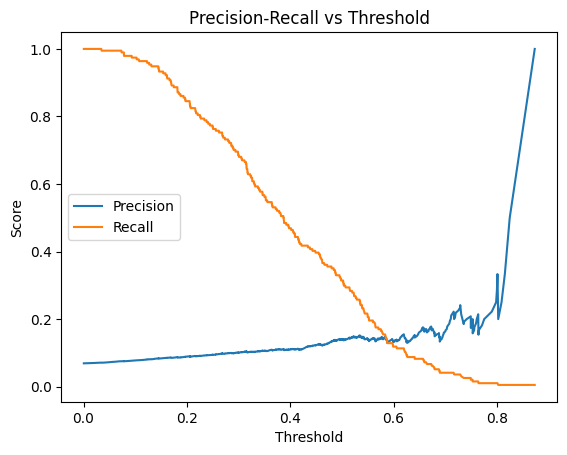

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc

#code for threshold tuning visualization
probs = xgb.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

import matplotlib.pyplot as plt

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.show()

# XGBOOST WITH THRESHOLD TUNING

**How to Choose the Best Threshold:**

Understand the Tradeoff:
1. Low threshold → high recall, low precision (catch more positives but also more false alarms).

2. High threshold → high precision, low recall (be more sure about positives, but miss many).



We need recall >=80 so threshold should be from 0.1=0.3.

In [ ]:
from sklearn.metrics import auc

# Get predicted probabilities for the positive class
y_probs = xgb.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Set custom threshold
threshold = 0.2

# Apply threshold to get predictions
y_pred_custom = (y_probs >= threshold).astype(int)

# Evaluate
print(classification_report(y_test, y_pred_custom))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))
print("AUROC Score:", roc_auc_score(y_test, y_probs))

# Calculate area under the PR curve
pr_auc = auc(recall, precision)

print(f"PR-AUC Score: {pr_auc:.4f}")

              precision    recall  f1-score   support

           0       0.97      0.36      0.52      2614
           1       0.09      0.85      0.16       194

    accuracy                           0.39      2808
   macro avg       0.53      0.60      0.34      2808
weighted avg       0.91      0.39      0.50      2808

Confusion Matrix:
 [[ 940 1674]
 [  30  164]]
AUROC Score: 0.6620122417750574
PR-AUC Score: 0.1222


After lowering the prediction threshold to 0.2, we observed a significant increase in recall for the positive class to 85%, meaning the model detects most readmissions. However, this comes with a sharp drop in precision to 9%, indicating many false alarms. Overall accuracy dropped to 39%, reflecting the trade-off between catching more positives and raising false positives. The AUROC remains the same at 0.66, while PR-AUC slightly improved to 0.12, showing a better balance in precision-recall at this threshold.

# XGBOOST with BorderlineSMOTE

In [39]:
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE
#i tried the above kmeans+SMOTE (total failure fr)
from imblearn.pipeline import Pipeline

from imblearn.over_sampling import BorderlineSMOTE #still bekaar result hai...

pipeline = Pipeline([
    ('smote', BorderlineSMOTE(random_state=42))
])

X_res, y_res = pipeline.fit_resample(X_train, y_train)

In [40]:
# 1. Train XGBoost on resampled data
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_res, y_res)

# 2. Predict on original test set
y_probs = xgb_model.predict_proba(X_test)[:, 1]

# 3. Apply custom threshold (e.g., 0.2)
threshold = 0.2
y_pred_custom = (y_probs >= threshold).astype(int)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:40:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [41]:
# 4. Evaluate
print("\nClassification Report:\n", classification_report(y_test, y_pred_custom))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))
print("AUROC Score:", roc_auc_score(y_test, y_probs))

# 5. PR-AUC
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)
print(f"PR-AUC Score: {pr_auc:.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.64      0.77      2614
           1       0.11      0.58      0.18       194

    accuracy                           0.64      2808
   macro avg       0.53      0.61      0.47      2808
weighted avg       0.90      0.64      0.73      2808

Confusion Matrix:
 [[1674  940]
 [  81  113]]
AUROC Score: 0.6515856332673392
PR-AUC Score: 0.1124


We applied BorderlineSMOTE to oversample the minority class before training XGBoost. This improved recall to 58%, showing better detection of positive cases, but precision remained low at 11%, indicating many false positives. Overall accuracy was 64%, higher than the low-threshold model but still moderate. AUROC dropped slightly to 0.65, and PR-AUC was 0.11, reflecting modest gains in balancing recall and precision but overall limited performance improvement.

We tried various under-sampling techniques on XGBoost, including random under-sampling and controlled sampling with a 3:1 ratio, but these approaches did not improve results. Therefore, we removed the code to keep the workflow clean.

# **SHAP ANALYSIS**

In [43]:
import shap
import matplotlib.pyplot as plt

# 1. Create SHAP explainer for our trained model
explainer = shap.TreeExplainer(xgb)

# 2. Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

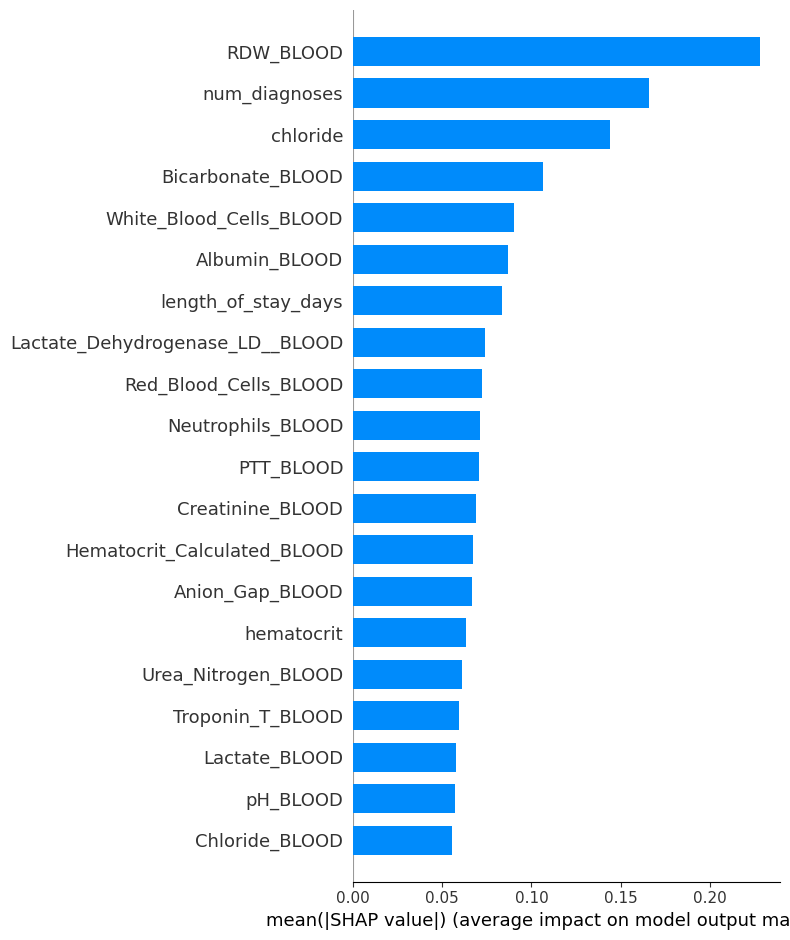

In [44]:
# 3. Summary plot — shows feature importance and effect direction
shap.summary_plot(shap_values, X_test, plot_type="bar")

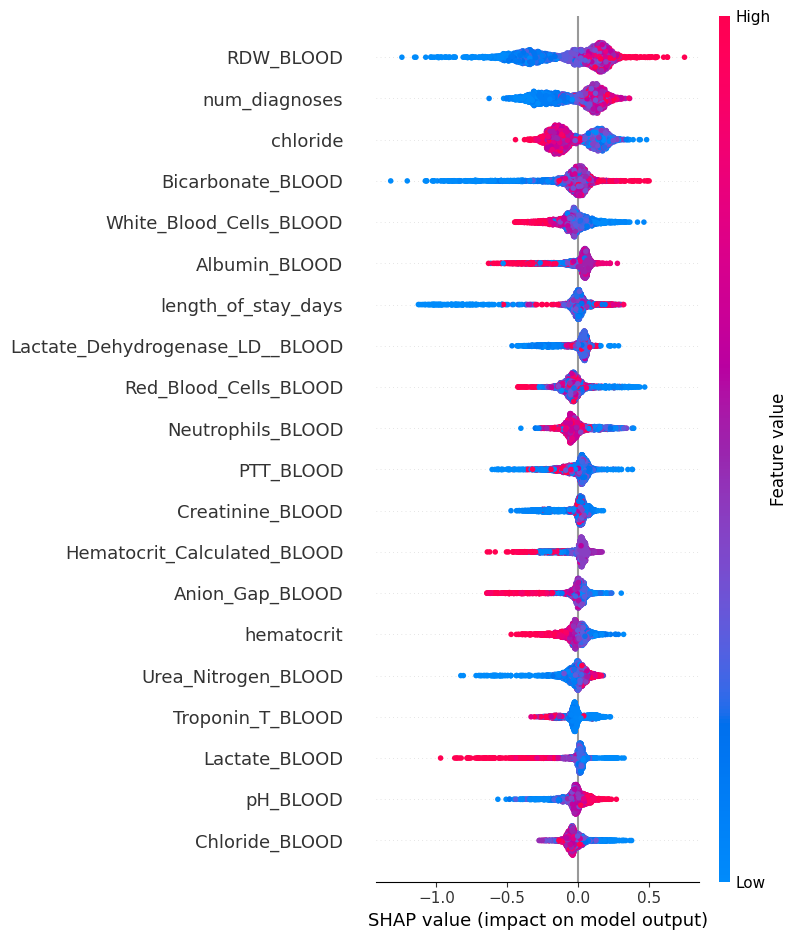

In [45]:
# 4. (Optional) Detailed summary dot plot
shap.summary_plot(shap_values, X_test)


#LightGBM Classifier



###on original dataset (without sampling)

In [46]:
import lightgbm as lgb

# 1. Initialize LightGBM with imbalance handling
lgb_model = lgb.LGBMClassifier(
    random_state=42,
    class_weight='balanced',  # Important for imbalance
    n_estimators=100,
    learning_rate=0.05,
    num_leaves=31
)

# 2. Fit on training data (you can use SMOTE or not depending on your combo)
lgb_model.fit(X_train, y_train)

# 3. Predict probabilities
y_probs = lgb_model.predict_proba(X_test)[:, 1]


[LightGBM] [Info] Number of positive: 774, number of negative: 10458
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11136
[LightGBM] [Info] Number of data points in the train set: 11232, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


In [47]:
# 4. Set custom threshold
threshold = 0.2
y_pred_custom = (y_probs >= threshold).astype(int)

# 5. Evaluation
print(classification_report(y_test, y_pred_custom))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))
print("AUROC Score:", roc_auc_score(y_test, y_probs))

# 6. PR-AUC calculation
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)
print("PR-AUC Score:", pr_auc)

              precision    recall  f1-score   support

           0       0.98      0.31      0.47      2614
           1       0.09      0.91      0.16       194

    accuracy                           0.35      2808
   macro avg       0.53      0.61      0.32      2808
weighted avg       0.92      0.35      0.45      2808

Confusion Matrix:
 [[ 819 1795]
 [  18  176]]
AUROC Score: 0.6820194984973853
PR-AUC Score: 0.1222823924808306


## LightGBM with SMOTE


In [ ]:
from lightgbm import LGBMClassifier
lgb_model_smote = LGBMClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.05,
    num_leaves=31,
    class_weight=None  # SMOTE already balances, so no weighting
)

lgb_model_smote.fit(X_train_smote, y_train_smote)
y_probs_smote = lgb_model_smote.predict_proba(X_test)[:, 1]

threshold = 0.2
y_pred_custom = (y_probs_smote >= threshold).astype(int)

# Classification report and metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred_custom))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))
print("AUROC Score:", roc_auc_score(y_test, y_probs_smote))

# 6. PR-AUC
precision, recall, _ = precision_recall_curve(y_test, y_probs_smote)
pr_auc = auc(recall, precision)
print("PR-AUC Score:", pr_auc)


[LightGBM] [Info] Number of positive: 10458, number of negative: 10458
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11924
[LightGBM] [Info] Number of data points in the train set: 20916, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.69      0.80      2614
           1       0.11      0.52      0.18       194

    accuracy                           0.68      2808
   macro avg       0.53      0.61      0.49      2808
weighted avg       0.89      0.68      0.76      2808

Confusion Matrix:
 [[1813  801]
 [  93  101]]
AUROC Score: 0.6527628787101966
PR-AUC Score: 0.11665324794663509


# LightGBM+ SMOTEENN

This didn't improve the result (code removed)

## LOGISTIC REGRESSION

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt

# 1. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Train Logistic Regression
lr = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=5000, random_state=42)
lr.fit(X_train_scaled, y_train)

# 3. Predict probabilities
y_probs = lr.predict_proba(X_test_scaled)[:, 1]


In [49]:
# 4. Set custom threshold
threshold = 0.1 # try tuning this value
y_pred_custom = (y_probs >= threshold).astype(int)

# 5. Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred_custom))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))
print("AUROC Score:", roc_auc_score(y_test, y_probs))

# 6. PR-AUC calculation
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)
print("PR-AUC Score:", pr_auc)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.01      0.03      2614
           1       0.07      1.00      0.13       194

    accuracy                           0.08      2808
   macro avg       0.53      0.51      0.08      2808
weighted avg       0.94      0.08      0.03      2808

Confusion Matrix:
 [[  34 2580]
 [   0  194]]
AUROC Score: 0.6833643584505321
PR-AUC Score: 0.12205058330783328


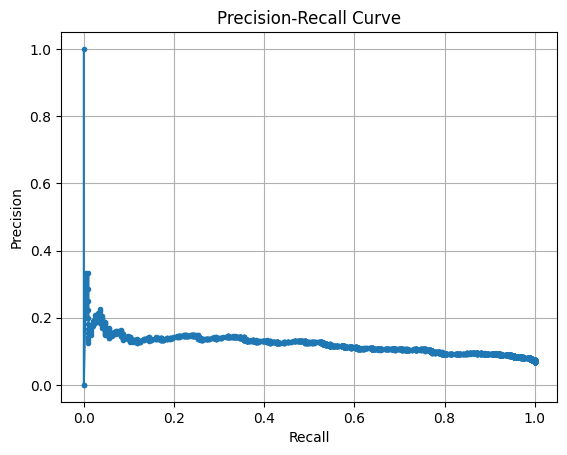

In [50]:
# 7. Plot Precision-Recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# Stacking/Ensembling

Ensembling combines predictions from multiple models to improve performance.
Stacking is a type of ensemble method that uses a meta-model (e.g., Logistic Regression) to learn from the outputs of base models (e.g., RandomForest, XGBoost, etc.).

In [51]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Scale your data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Extract features and target
X = hf_model_data.drop(columns=['readmit_30_days'])
y = hf_model_data['readmit_30_days']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# Base models
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# Meta-model
meta_model = LogisticRegression()

# Stacking classifier
stacked_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model, cv=5, n_jobs=-1)



In [52]:
# Train
stacked_model.fit(X_train, y_train)

# Predict
y_pred = stacked_model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2614
           1       0.33      0.01      0.02       194

    accuracy                           0.93      2808
   macro avg       0.63      0.50      0.49      2808
weighted avg       0.89      0.93      0.90      2808



# Balanced Bagging Classifier

In [ ]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bbc = BalancedBaggingClassifier(
    estimator=DecisionTreeClassifier(),
    sampling_strategy='auto',
    replacement=False,
    random_state=42,
    n_estimators=50,
    n_jobs=-1
)

bbc.fit(X_train, y_train)

y_probs = bbc.predict_proba(X_test)[:, 1]
y_pred = (y_probs >= 0.2).astype(int)

print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.99      0.25      0.40      2614
           1       0.09      0.97      0.16       194

    accuracy                           0.30      2808
   macro avg       0.54      0.61      0.28      2808
weighted avg       0.93      0.30      0.38      2808



In [53]:
from joblib import dump

# Save the trained EasyEnsembleClassifier model
dump(eec, 'easy_ensemble_model.joblib')

['easy_ensemble_model.joblib']

In [54]:
from joblib import load

# Load the model from the file
eec_loaded = load('easy_ensemble_model.joblib')
